In [1]:
import os
import glob
import re
import random
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from collections import deque

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [2]:
def load_concentration_data(m_dir, A_dir):
    domains = []
    for dnum in range(1, 2401):
        m_path = os.path.join(m_dir, f"m{dnum}.npz")
        A_path = os.path.join(A_dir, f"A{dnum}.npz")
        if not (os.path.exists(m_path) and os.path.exists(A_path)):
            continue
        with np.load(m_path) as d:
            m_raw = d['mask']
            m = m_raw.reshape((64,148)) if m_raw.size == 9472 else m_raw
            m = (m > 0.5).astype(np.int32)    # <--- 0.5 기준 이진화!
        with np.load(A_path) as d:
            A = d['A']
            A = A.reshape((160,64,148)) if A.shape[-1] == 9472 else A  # (T,64,148)
        domains.append({'domain_num':dnum, 'm':m, 'A':A})
    return domains


In [3]:
##########################
# 2. k2 변환 & sdf 생성
##########################
def domainnum_to_k2(domain_num):
    if 1 <= domain_num <= 800:      return 0.0
    elif 801 <= domain_num <= 1600: return 0.1
    elif 1601 <= domain_num <= 2400: return 0.2
    else: raise ValueError(f"{domain_num} 범위 이상")

def norm_k2(k2):  # 0→0, 0.1→0.5, 0.2→1
    return k2 / 0.2

def create_distance_map_from_pivots(grid, start_range=(28,36)):
    if grid is None or grid.size == 0:
        return np.zeros((64,148))
    rows, cols = grid.shape
    sr, er = start_range
    starts = [(i, 0) for i in range(sr, er)]
    valid = [pt for pt in starts if grid[pt] == 1]
    dist = np.full((rows, cols), -1, dtype=np.int32)
    if not valid:
        return dist
    queue = deque([(pt, 0) for pt in valid])
    visited = set(valid)
    dirs = [(-1,0),(0,1),(1,0),(0,-1)]
    while queue:
        (r, c), d = queue.popleft()
        if dist[r,c] < 0 or d < dist[r,c]:
            dist[r,c] = d
        for dr, dc in dirs:
            nr, nc = r+dr, c+dc
            if 0 <= nr < rows and 0 <= nc < cols and (nr,nc) not in visited and grid[nr,nc] == 1:
                visited.add((nr,nc))
                queue.append(((nr,nc), d+1))
    return dist

In [4]:
##########################
# 3. 샘플 생성 함수
##########################
def process_concentration_domain(domain_data, nx=64, ny=148, t_primes=None, pivot_range=(28,36)):
    if t_primes is None:
        t_primes = np.linspace(0, 1, 21)
    dnum = domain_data['domain_num']
    m = domain_data['m']
    A_series = domain_data['A']
    k2 = domainnum_to_k2(dnum)
    k2_norm = norm_k2(k2)

    branch1_input = m.reshape((1, nx, ny))
    branch2_input = np.array([k2_norm], dtype=np.float32)

    sdf = create_distance_map_from_pivots(m, start_range=pivot_range).astype(np.float32)
    sdf[sdf < 0] = 0
    if np.any(m > 0):
        sdf_min, sdf_max = sdf[m > 0].min(), sdf[m > 0].max()
        sdf_norm = np.zeros_like(sdf)
        sdf_norm[m > 0] = (sdf[m > 0] - sdf_min) / (sdf_max - sdf_min + 1e-8)
    else:
        sdf_norm = np.zeros_like(sdf)
    sdf_norm[m == 0] = 0

    x = np.arange(nx, dtype=np.float32)
    y = np.arange(ny, dtype=np.float32)
    X, Y = np.meshgrid(x, y, indexing='ij')
    x_flat, y_flat = X.flatten(), Y.flatten()
    sdf_flat = sdf_norm.flatten()

    branch1_list, branch2_list, trunk_list, target_list = [], [], [], []
    T = A_series.shape[0]

    for t_prime in t_primes:
        k = int(round(t_prime * (T-1)))
        k = max(0, min(k, T-1))
        A_t = A_series[k].astype(np.float32)
        t_chan = np.full((nx*ny,), t_prime, dtype=np.float32)
        trunk_q = np.stack([x_flat, y_flat, sdf_flat, t_chan], axis=1)  # (nx*ny,4)
        branch1_list.append(branch1_input)
        branch2_list.append(branch2_input)
        trunk_list.append(trunk_q)
        target_list.append(A_t[..., np.newaxis])  # (64,148,1)
    return branch1_list, branch2_list, trunk_list, target_list

def build_concentration_dataset(domains, nx=64, ny=148, t_primes=None, pivot_range=(28,36)):
    b1_all, b2_all, t_all, tgt_all = [], [], [], []
    for d in domains:
        b1, b2, t, tgt = process_concentration_domain(d, nx, ny, t_primes, pivot_range)
        b1_all.extend(b1)
        b2_all.extend(b2)
        t_all.extend(t)
        tgt_all.extend(tgt)
    b1_arr = np.stack(b1_all, axis=0)
    b2_arr = np.stack(b2_all, axis=0)
    t_arr  = np.stack(t_all, axis=0)
    tgt_arr = np.stack(tgt_all, axis=0)
    b1_tensor = torch.tensor(b1_arr, dtype=torch.float32)
    b2_tensor = torch.tensor(b2_arr, dtype=torch.float32)
    t_tensor  = torch.tensor(t_arr, dtype=torch.float32)
    tgt_tensor = torch.tensor(tgt_arr, dtype=torch.float32)
    return b1_tensor, b2_tensor, t_tensor, tgt_tensor

In [5]:
##########################
# 4. 데이터셋 분할
##########################
m_dir = "/home/yehoon/npz/amv/k2_data"
A_dir = "/home/yehoon/npz/amv/k2_data_time"
all_domains = load_concentration_data(m_dir, A_dir)

# 1~800, 801~1600, 1601~2400 → k2별 그룹
g1 = [d for d in all_domains if 1 <= d['domain_num'] <= 800]
g2 = [d for d in all_domains if 801 <= d['domain_num'] <= 1600]
g3 = [d for d in all_domains if 1601 <= d['domain_num'] <= 2400]

random.seed(42)
def split(g, n): random.shuffle(g); return g[:n], g[n:]
tr1, te1 = split(g1, 720)
tr2, te2 = split(g2, 720)
tr3, te3 = split(g3, 720)
train_domains = tr1+tr2+tr3
test_domains  = te1+te2+te3

# t' 리스트
# t_primes = [0.05, 0.25, 0.5, 0.75, 1.0]
t_primes = np.linspace(0, 1, 21)

# 데이터셋 생성
train_b1, train_b2, train_trunk, train_tgt = build_concentration_dataset(train_domains, t_primes=t_primes)
test_b1, test_b2, test_trunk, test_tgt = build_concentration_dataset(test_domains, t_primes=t_primes)

train_ds = TensorDataset(train_b1, train_b2, train_trunk, train_tgt)
test_ds  = TensorDataset(test_b1, test_b2, test_trunk, test_tgt)

In [6]:
##########################
# 5. 모델 정의
##########################
class BasicCNN(nn.Module):
    def __init__(self, in_ch, out_dim):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_ch,16,3,1,1), nn.SiLU(), nn.AvgPool2d(2),
            nn.Conv2d(16,32,3,1,1), nn.SiLU(), nn.AvgPool2d(2),
            nn.Conv2d(32,64,3,1,1), nn.SiLU(), nn.AvgPool2d(2)
        )
        self.fc = nn.Linear(64*8*18, out_dim)
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class BasicMLP(nn.Module):
    def __init__(self, in_dim, out_dim, num_layers=2, width=32):
        super().__init__()
        layers = [nn.Linear(in_dim, width), nn.SiLU()]
        for _ in range(num_layers-2):
            layers += [nn.Linear(width, width), nn.SiLU()]
        layers += [nn.Linear(width, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class ConcentrationDeepONet2Branch(nn.Module):
    def __init__(self, branch1_in=1, branch2_in=1, trunk_in=4, out_dim=80,
                 branch2_width=32, trunk_layers=4, trunk_width=80,
                 nx=64, ny=148):
        super().__init__()
        self.branch1 = BasicCNN(branch1_in, out_dim)
        self.branch2 = BasicMLP(branch2_in, out_dim, num_layers=2, width=branch2_width)
        trunk_layers = max(trunk_layers, 2)
        layers = [nn.Linear(trunk_in, trunk_width), nn.SiLU()]
        for _ in range(trunk_layers-2):
            layers += [nn.Linear(trunk_width, trunk_width), nn.SiLU()]
        layers += [nn.Linear(trunk_width, out_dim)]
        self.trunk = nn.Sequential(*layers)
        self.bias = nn.Parameter(torch.zeros(1))
        self.nx, self.ny = nx, ny
    def forward(self, b1, b2, t):
        N, L, _ = t.shape
        b1_out = self.branch1(b1).unsqueeze(1)    # (N,1,q)
        b2_out = self.branch2(b2).unsqueeze(1)    # (N,1,q)
        trunk_out = self.trunk(t.view(-1, t.shape[-1])).view(N, L, -1)  # (N,L,q)
        fused = b1_out * b2_out * trunk_out       # (N,L,q)
        out = fused.sum(-1) + self.bias           # (N,L)
        return out.view(N, self.nx, self.ny, 1)

In [7]:
##########################
# 6. 학습 및 평가
##########################
def train_model(model, train_ds, test_ds, num_epochs=500, lr=0.001, batch_size=25, patience=15):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    criterion = nn.HuberLoss(delta=1.0)
    scaler = torch.cuda.amp.GradScaler()

    class EarlyStopping:
        def __init__(self, patience=10, delta=1e-5, verbose=False):
            self.patience = patience
            self.delta = delta
            self.verbose = verbose
            self.counter = 0
            self.best_loss = None
            self.early_stop = False
            self.best_model_state = None
        def __call__(self, val_loss, model):
            if self.best_loss is None or val_loss < self.best_loss - self.delta:
                self.best_loss = val_loss
                self.counter = 0
                self.best_model_state = copy.deepcopy(model.state_dict())
                if self.verbose:
                    print(f"Validation loss decreased. New best loss: {val_loss:.6f}")
            else:
                self.counter += 1
                if self.verbose:
                    print(f"No improvement in validation loss. Counter: {self.counter}/{self.patience}")
                if self.counter >= self.patience:
                    self.early_stop = True
    early_stopping = EarlyStopping(patience=patience, delta=1e-5, verbose=True)
    train_losses, test_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        for b1, b2, t, tgt in train_loader:
            b1, b2, t, tgt = b1.to(device), b2.to(device), t.to(device), tgt.to(device)
            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                preds = model(b1, b2, t)
                loss = criterion(preds, tgt)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            running_train_loss += loss.item()
        avg_train_loss = running_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        model.eval()
        running_test_loss = 0.0
        with torch.no_grad():
            for b1, b2, t, tgt in test_loader:
                b1, b2, t, tgt = b1.to(device), b2.to(device), t.to(device), tgt.to(device)
                with torch.cuda.amp.autocast():
                    preds = model(b1, b2, t)
                    loss = criterion(preds, tgt)
                running_test_loss += loss.item()
        avg_test_loss = running_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Train Loss: {avg_train_loss:.6f}, Test Loss: {avg_test_loss:.6f}")
        early_stopping(avg_test_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered. Restoring best model state.")
            model.load_state_dict(early_stopping.best_model_state)
            break
    return train_losses, test_losses

def evaluate_model(model, test_ds, batch_size=25):
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    criterion = nn.HuberLoss(delta=1.0)
    total_loss = 0
    with torch.no_grad():
        for b1, b2, t, tgt in test_loader:
            b1, b2, t, tgt = b1.to(device), b2.to(device), t.to(device), tgt.to(device)
            preds = model(b1, b2, t)
            loss = criterion(preds, tgt)
            total_loss += loss.item()
    avg_loss = total_loss / len(test_loader)
    print("Average Test Loss:", avg_loss)
    return avg_loss

In [8]:
##########################
# 7. 간단 시각화 예시 (테스트 샘플)
##########################
def apply_candidate_correction(field, mask):
    corrected = field.copy()
    mineral_mask = (mask == 0)
    if corrected.ndim == 3:
        mineral_mask_3d = np.repeat(mineral_mask[:, :, np.newaxis], corrected.shape[2], axis=2)
        corrected[mineral_mask_3d] = 0
    else:
        corrected[mineral_mask] = 0
    return corrected

def evaluate_sample_concentration(model, branch_tensor, branch2_tensor, trunk_tensor, target_tensor, sample_idx):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        sb1 = branch_tensor[sample_idx:sample_idx+1].to(device)
        sb2 = branch2_tensor[sample_idx:sample_idx+1].to(device)
        st = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(sb1, sb2, st).cpu().numpy()[0]
        actual = target_tensor[sample_idx].cpu().numpy()
    return preds, actual

In [9]:
# --- 학습 & 평가 ---
model = ConcentrationDeepONet2Branch(
    branch1_in=1, branch2_in=1, trunk_in=4, out_dim=80,
    branch2_width=80, trunk_layers=5, trunk_width=80,
    nx=64, ny=148
)

train_losses, test_losses = train_model(
    model, train_ds, test_ds, num_epochs=500, lr=1e-3, batch_size=25, patience=15
)

evaluate_model(model, test_ds)

/tmp/ipykernel_1100022/1993049501.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_1100022/1993049501.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/tmp/ipykernel_1100022/1993049501.py:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/500] Train Loss: 0.009403, Test Loss: 0.004694
Validation loss decreased. New best loss: 0.004694
Epoch [2/500] Train Loss: 0.002422, Test Loss: 0.002428
Validation loss decreased. New best loss: 0.002428
Epoch [3/500] Train Loss: 0.001224, Test Loss: 0.000854
Validation loss decreased. New best loss: 0.000854
Epoch [4/500] Train Loss: 0.000769, Test Loss: 0.000727
Validation loss decreased. New best loss: 0.000727
Epoch [5/500] Train Loss: 0.000543, Test Loss: 0.000482
Validation loss decreased. New best loss: 0.000482
Epoch [6/500] Train Loss: 0.000338, Test Loss: 0.000335
Validation loss decreased. New best loss: 0.000335
Epoch [7/500] Train Loss: 0.000315, Test Loss: 0.000289
Validation loss decreased. New best loss: 0.000289
Epoch [8/500] Train Loss: 0.000290, Test Loss: 0.000228
Validation loss decreased. New best loss: 0.000228
Epoch [9/500] Train Loss: 0.000224, Test Loss: 0.000599
No improvement in validation loss. Counter: 1/15
Epoch [10/500] Train Loss: 0.000182, Te

8.951850716107626e-05

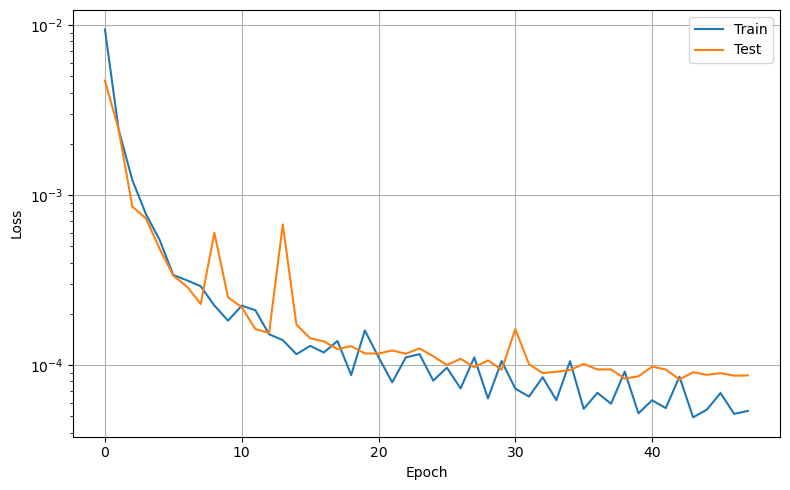

In [10]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train')
plt.plot(test_losses, label='Test')
plt.yscale('log'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
plt.tight_layout()
plt.show()

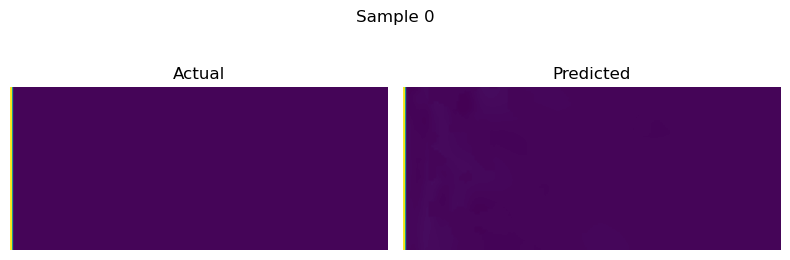

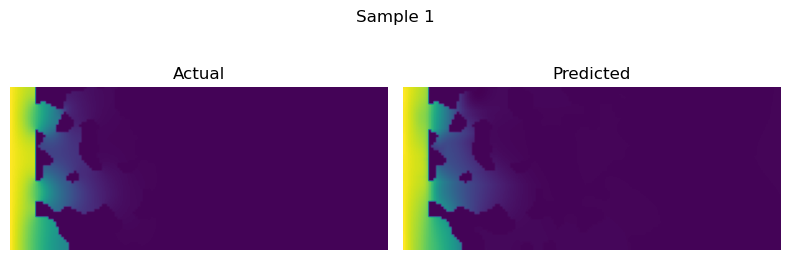

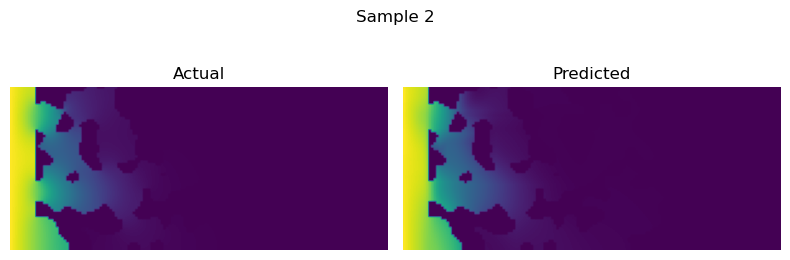

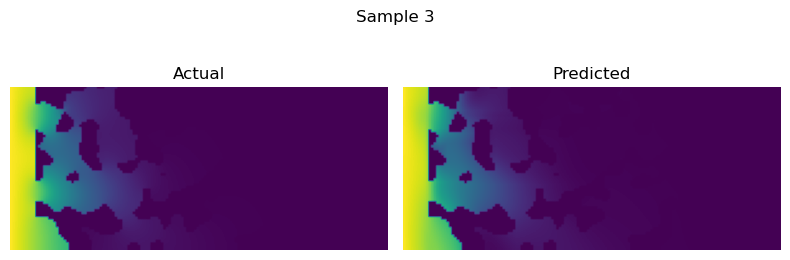

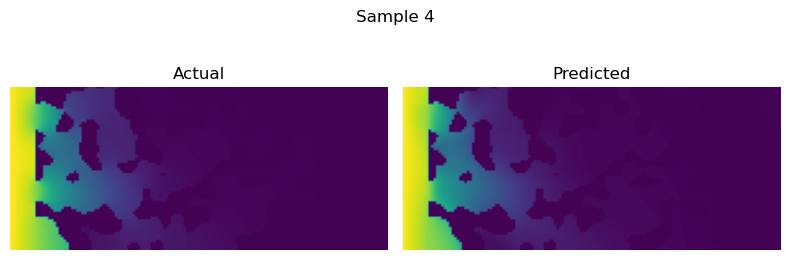

In [11]:
for i in range(5):
    preds, actual = evaluate_sample_concentration(
        model, test_b1, test_b2, test_trunk, test_tgt, i
    )
    mask = test_b1[i,0].numpy()
    preds_corr  = apply_candidate_correction(preds, mask)
    actual_corr = apply_candidate_correction(actual, mask)
    vmin = min(preds_corr.min(), actual_corr.min())
    vmax = max(preds_corr.max(), actual_corr.max())
    plt.figure(figsize=(8,3))
    plt.subplot(1,2,1)
    plt.imshow(actual_corr.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title("Actual")
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(preds_corr.squeeze(), cmap='viridis', vmin=vmin, vmax=vmax)
    plt.title("Predicted")
    plt.axis('off')
    plt.suptitle(f"Sample {i}")
    plt.tight_layout()
    plt.show()

In [12]:
# import matplotlib.pyplot as plt

# # 1) 도메인과 시점 리스트 정의
# domain_indices = [0, 200, 400]
# t_primes       = [0.0, 0.04, 0.08, 0.12, 0.16, 0.20, 0.24, 0.28, 0.32, 0.36]
# selected_tps   = [0.04, 0.08, 0.12, 0.20]

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# # 2) 한 도메인 당 (2행 × len(selected_tps)열) 서브플롯 생성
# for d in domain_indices:
#     n_tp = len(selected_tps)
#     fig, axes = plt.subplots(
#         nrows=2, ncols=n_tp,
#         figsize=(n_tp*3, 2*3),
#         constrained_layout=True
#     )
    
#     for j, tp in enumerate(selected_tps):
#         # 전체 스택된 샘플에서의 인덱스 계산
#         j_all = t_primes.index(tp)
#         sample_idx = d * len(t_primes) + j_all
        
#         # 모델 예측 및 실제값 불러오기
#         sb = test_branch.to(device)[sample_idx:sample_idx+1]
#         st = test_trunk.to(device)[sample_idx:sample_idx+1]
#         with torch.no_grad():
#             pred = model(sb, st).cpu().numpy()[0]    # (64,148,1)
#         actual = test_tgt[sample_idx].numpy()       # (64,148,1)

#         # 역정규화 및 후보정
#         pred_dn  = inverse_normalize(pred, p_te[sample_idx])
#         actual_dn= inverse_normalize(actual, p_te[sample_idx])
#         mask     = test_branch[sample_idx,0].numpy()
#         pred_corr   = apply_candidate_correction(pred_dn,  mask)
#         actual_corr = apply_candidate_correction(actual_dn, mask)

#         # 첫째 행: 실제
#         ax = axes[0, j]
#         im = ax.imshow(actual_corr.squeeze(), origin='lower')
#         ax.set_title(f"Pred t'={tp/0.20:.1f}")
#         ax.axis('off')

#         # 둘째 행: 예측
#         ax = axes[1, j]
#         ax.imshow(pred_corr.squeeze(), vmin=im.get_clim()[0], vmax=im.get_clim()[1], origin='lower')
#         ax.set_title(f"Pred t'={tp/0.20:.1f}")
#         ax.axis('off')

#     fig.suptitle(f"Domain {d}", fontsize=16)
#     plt.savefig(f"domain_{d}.png")
#     plt.show()


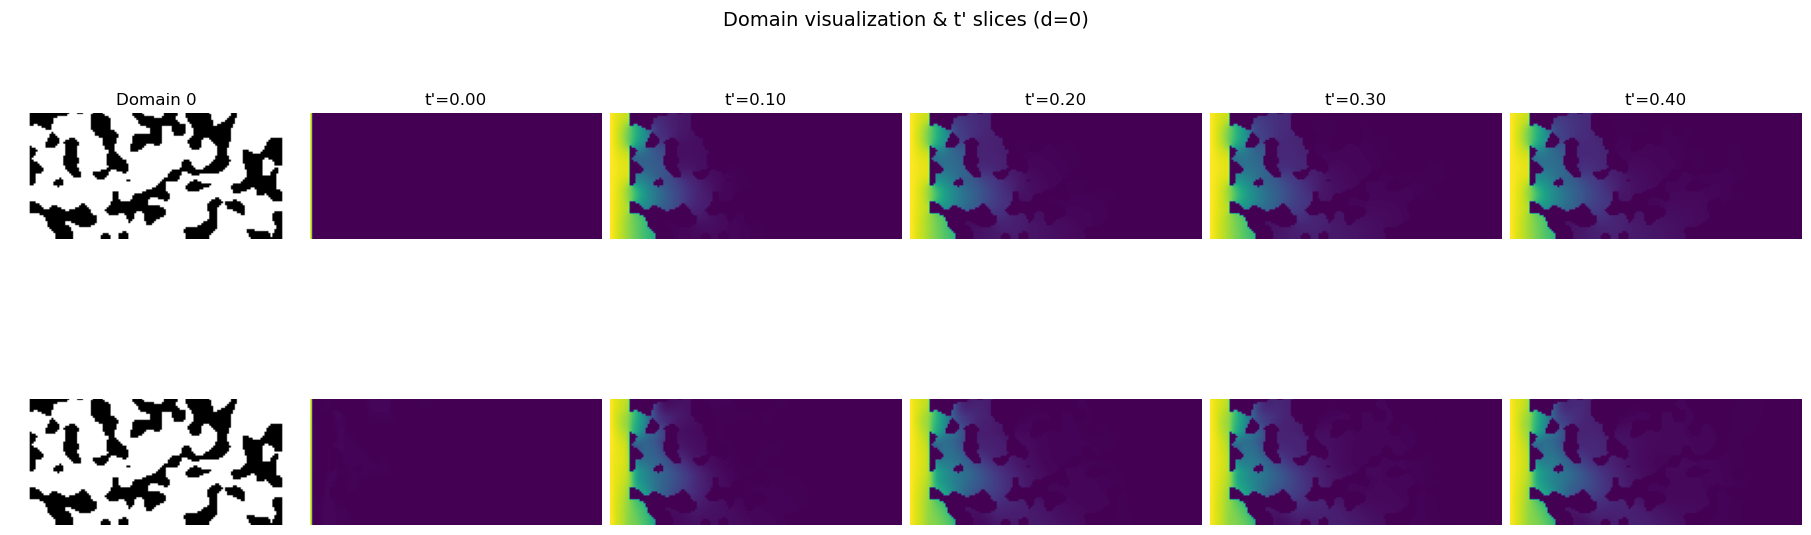

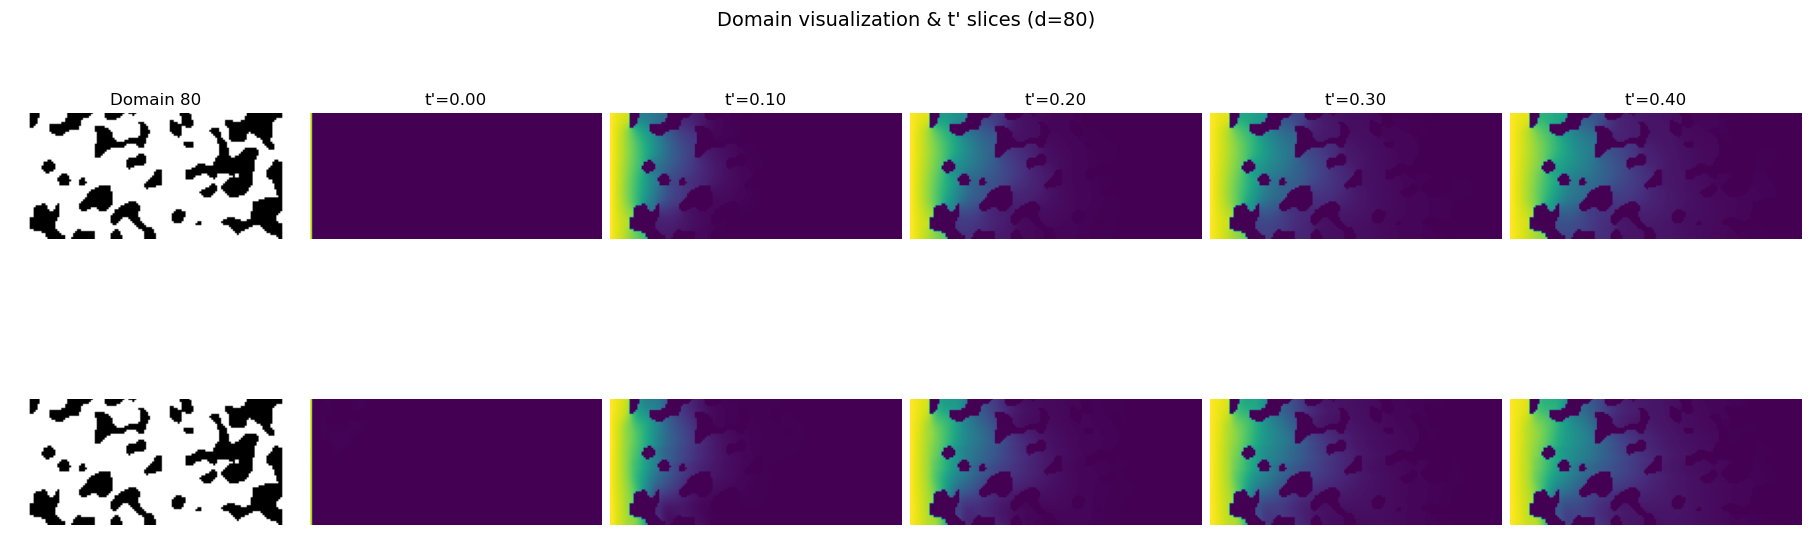

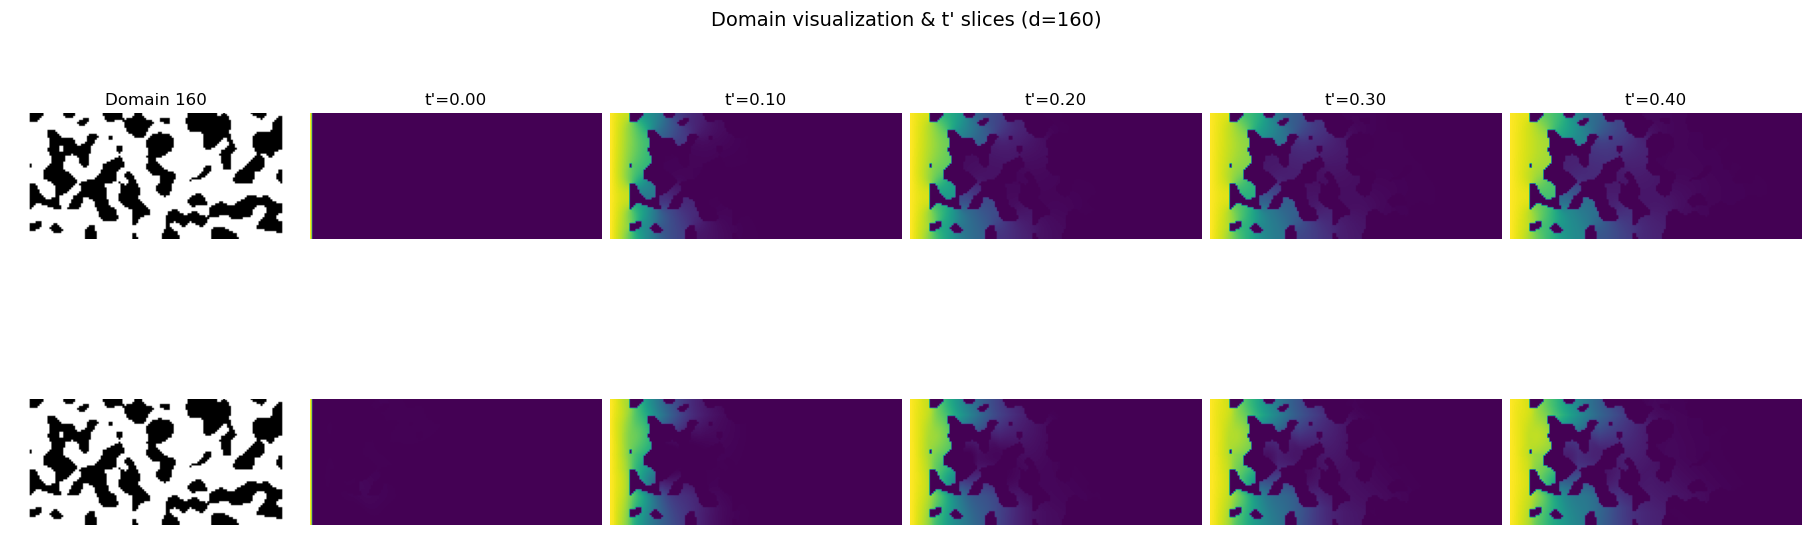

In [13]:
t_primes = np.linspace(0, 1, 21)    # [0.00, 0.05, 0.10, ..., 0.95, 1.00]
selected_tps = [0, 0.10, 0.20, 0.30, 0.40]
domain_indices = [0, 80, 160]

device = torch.device('cpu')
model.to(device)
model.eval()

for d in domain_indices:
    n_tp = len(selected_tps) + 1
    fig, axes = plt.subplots(
        nrows=2, ncols=n_tp,
        figsize=(n_tp * 3, 2 * 3),
        constrained_layout=True
    )

    # (가) 첫 열: 도메인 마스크
    domain_mask = test_domains[d]['m']  # shape (64,148)
    for row in range(2):
        ax = axes[row, 0]
        ax.imshow(domain_mask, cmap='gray')
        if row == 0:
            ax.set_title(f"Domain {d}", fontsize=12)
        ax.axis('off')

    # (나) 나머지 열: t'별 Actual/Predicted
    for j, tp in enumerate(selected_tps):
        col = j + 1
        # numpy에서 index 찾기! (np.isclose을 써야 안전)
        j_all = np.where(np.isclose(t_primes, tp))[0][0]
        sample_idx = d * len(t_primes) + j_all

        # CPU에서 바로 슬라이싱해서 사용
        sb1 = test_b1[sample_idx:sample_idx+1]
        sb2 = test_b2[sample_idx:sample_idx+1]
        st  = test_trunk[sample_idx:sample_idx+1]
        with torch.no_grad():
            pred = model(sb1, sb2, st).detach().numpy()[0]    # (64,148,1)
        actual = test_tgt[sample_idx].numpy()                 # (64,148,1)

        mask = test_b1[sample_idx,0].numpy()
        pred_corr   = apply_candidate_correction(pred,  mask)
        actual_corr = apply_candidate_correction(actual, mask)

        # 실제값
        ax0 = axes[0, col]
        im = ax0.imshow(actual_corr.squeeze())
        ax0.set_title(f"t'={tp:.2f}", fontsize=12)
        ax0.axis('off')

        # 예측값
        ax1 = axes[1, col]
        ax1.imshow(pred_corr.squeeze(), vmin=im.get_clim()[0], vmax=im.get_clim()[1])
        ax1.axis('off')

    # 저장 및 표시
    fig.suptitle(f"Domain visualization & t' slices (d={d})", fontsize=14)
    plt.savefig(f"domain_{d}_with_mask.svg", dpi=150)
    plt.show()

In [14]:
from collections import defaultdict

# test_domains에서 domain_num만 리스트로
domain_nums = [d['domain_num'] for d in test_domains]

# base_id 계산: 1~2000로 매핑 (k2 버전이면 800 단위)
def to_base(dnum):
    # 1~800 → 1~800, 801~1600→1~800, 1601~2400→1~800
    # 혹은 2000 단위라면 ((dnum-1)%2000)+1
    return ((dnum - 1) % 800) + 1   # 800 버전이면 이걸로!

# base_id별로 묶기
groups = defaultdict(list)
for dnum in domain_nums:
    b = to_base(dnum)
    groups[b].append(dnum)

# 2개 이상 존재하는 base_id만 필터링
duplicates = {b: sorted(ids) for b, ids in groups.items() if len(ids) > 1}

# 결과 출력
for base_id, variants in duplicates.items():
    print(f"원본 도메인 {base_id}번: 시뮬레이션된 domain_num =", variants)


원본 도메인 465번: 시뮬레이션된 domain_num = [465, 1265]
원본 도메인 297번: 시뮬레이션된 domain_num = [297, 1897]
원본 도메인 47번: 시뮬레이션된 domain_num = [47, 847]
원본 도메인 197번: 시뮬레이션된 domain_num = [197, 997]
원본 도메인 371번: 시뮬레이션된 domain_num = [371, 1971]
원본 도메인 644번: 시뮬레이션된 domain_num = [644, 2244]
원본 도메인 81번: 시뮬레이션된 domain_num = [81, 1681]
원본 도메인 471번: 시뮬레이션된 domain_num = [471, 2071]
원본 도메인 353번: 시뮬레이션된 domain_num = [353, 1153]
원본 도메인 390번: 시뮬레이션된 domain_num = [390, 1990]
원본 도메인 715번: 시뮬레이션된 domain_num = [715, 1515]
원본 도메인 604번: 시뮬레이션된 domain_num = [604, 1404, 2204]
원본 도메인 617번: 시뮬레이션된 domain_num = [617, 2217]
원본 도메인 96번: 시뮬레이션된 domain_num = [96, 896]
원본 도메인 760번: 시뮬레이션된 domain_num = [760, 2360]
원본 도메인 588번: 시뮬레이션된 domain_num = [1388, 2188]
원본 도메인 106번: 시뮬레이션된 domain_num = [906, 1706]
원본 도메인 199번: 시뮬레이션된 domain_num = [999, 1799]
원본 도메인 707번: 시뮬레이션된 domain_num = [1507, 2307]
원본 도메인 783번: 시뮬레이션된 domain_num = [1583, 2383]
원본 도메인 544번: 시뮬레이션된 domain_num = [1344, 2144]
원본 도메인 250번: 시뮬레이션된 domain_num = [1050, 1850]
원본 도메인 4

In [15]:
base = 604

# 1) test_domains에서 "원본 1317번"에 해당하는 sample 인덱스 찾기
def to_base(dnum):
    # k2_data 저장시 1~800, 801~1600, 1601~2400 반복 구조라면
    return ((dnum - 1) % 800) + 1

domain_indices = [i for i, d in enumerate(test_domains)
                  if to_base(d['domain_num']) == base]

# 2) 파라미터
t_primes = np.linspace(0, 1, 21)                    # [0.00, 0.05, ..., 1.00]
selected_tps = [0.1, 0.2, 0.4, 0.6, 0.8]            # 원하는 t'만 사용

device = torch.device('cpu')                        # 무조건 CPU 사용
model.to(device)
model.eval()

for d in domain_indices:
    # orig_k2 계산 (Da 대신 k2로!)
    k2 = domainnum_to_k2(test_domains[d]['domain_num'])
    # k2 포매팅: 0이면 정수로, 아니면 소수점 1자리
    if np.isclose(k2, 0):
        k2_str = "0"
    else:
        k2_str = f"{k2:.1f}"

    # 그리드 셋업: 2행 × (1+1+len(selected_tps))열
    n_imgs = len(selected_tps)
    n_cols = 1 + 1 + n_imgs    # k2 컬럼 + label 컬럼 + 이미지 컬럼
    fig = plt.figure(figsize=(n_cols*2.5, 2.5*2))
    gs = GridSpec(2, n_cols, figure=fig,
                  width_ratios=[0.5, 0.2] + [1]*n_imgs,
                  wspace=0.05, hspace=0.05)

    # --- 첫 열: k2 텍스트 (두 행 span) ---
    ax_k2 = fig.add_subplot(gs[:, 0])
    ax_k2.axis('off')
    ax_k2.text(0.5, 0.5,
               f"k2 = {k2_str}",
               ha='center', va='center',
               fontsize=16, fontweight='bold',
               transform=ax_k2.transAxes)

    # --- 두 번째 열: (a) / (b) 레이블 ---
    ax_a = fig.add_subplot(gs[0, 1])
    ax_b = fig.add_subplot(gs[1, 1])
    for ax in (ax_a, ax_b):
        ax.axis('off')
    ax_a.text(0.5, 0.5, "(a)", ha='center', va='center',
              fontsize=14, fontweight='bold', transform=ax_a.transAxes)
    ax_b.text(0.5, 0.5, "(b)", ha='center', va='center',
              fontsize=14, fontweight='bold', transform=ax_b.transAxes)

    # --- 나머지 열: t' 시점별 Actual / Predicted ---
    shared_ax = None
    for j, tp in enumerate(selected_tps):
        # index 찾기: np.where + np.isclose 사용!
        idx_tp = np.where(np.isclose(t_primes, tp))[0][0]
        sample_idx = d * len(t_primes) + idx_tp

        # 실제 필드
        actual = test_tgt[sample_idx].numpy()           # (64,148,1)
        mask   = test_b1[sample_idx,0].numpy()          # (64,148)
        actual_corr = apply_candidate_correction(actual, mask)

        # 예측 필드 (2-branch)
        sb1 = test_b1[sample_idx:sample_idx+1]
        sb2 = test_b2[sample_idx:sample_idx+1]
        st  = test_trunk[sample_idx:sample_idx+1]
        with torch.no_grad():
            pred = model(sb1, sb2, st).detach().numpy()[0]  # (64,148,1)
        pred_corr = apply_candidate_correction(pred, mask)

        # Actual 히트맵 (row 0, col j+2)
        ax0 = fig.add_subplot(gs[0, j+2], sharex=shared_ax, sharey=shared_ax)
        im = ax0.imshow(actual_corr.squeeze(), cmap='viridis')
        ax0.set_title(f"t'={tp:.1f}", fontsize=12, pad=2)
        ax0.axis('off')

        # Predicted 히트맵 (row 1, col j+2)
        ax1 = fig.add_subplot(gs[1, j+2], sharex=ax0, sharey=ax0)
        ax1.imshow(pred_corr.squeeze(),
                   vmin=im.get_clim()[0],
                   vmax=im.get_clim()[1],
                   cmap='viridis')
        ax1.axis('off')

        if shared_ax is None:
            shared_ax = ax0

    # 전체 타이틀
    fig.suptitle(f"Domain: {base}, Test idx: {d}, k2={k2_str}", fontsize=14)
    plt.savefig(f"domain_{d}_k2.svg", dpi=150, bbox_inches='tight')
    plt.show()

NameError: name 'GridSpec' is not defined

<Figure size 1750x500 with 0 Axes>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

# t' 리스트 (process_concentration_domain와 동일하게 맞추세요)
t_primes     = [0.0, 0.04, 0.08, 0.12, 0.24, 0.36, 0.48, 0.60]
chunk_size   = 4
domain_indices = [1, 201, 401]  # 예시 도메인

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()

for d in domain_indices:
    # 이 도메인의 8개 샘플 인덱스 범위
    base_idx = d * len(t_primes)
    
    # 4개씩 두 번 반복
    for chunk_start in range(0, len(t_primes), chunk_size):
        chunk_tps = t_primes[chunk_start:chunk_start+chunk_size]
        sample_indices = [base_idx + t_primes.index(tp) for tp in chunk_tps]
        
        # 2행×4열 figure
        fig, axes = plt.subplots(2, chunk_size,
                                 figsize=(chunk_size*3, 2*3),
                                 constrained_layout=True)
        
        for j, idx in enumerate(sample_indices):
            # (1) 예측 & 실제 불러오기
            sb1 = test_b1.to(device)[idx:idx+1]
            sb2 = test_b2.to(device)[idx:idx+1]
            st  = test_trunk.to(device)[idx:idx+1]
            with torch.no_grad():
                pred = model(sb1, sb2, st).cpu().numpy()[0]    # (64,148,1)
            actual = test_tgt[idx].cpu().numpy()              # (64,148,1)

            # (2) 후보정만 적용 (정규화/역정규화 X)
            mask     = test_b1[idx,0].cpu().numpy()
            pred_corr   = apply_candidate_correction(pred,  mask)
            actual_corr = apply_candidate_correction(actual, mask)
            
            # (3) MAPE/NRMSE
            mape, nrmse = compute_mape_nrmse_concentration_corrected(
                pred_corr, actual_corr, mask
            )
            
            # — 첫째 행: 산점도
            ax0 = axes[0, j]
            ax0.scatter(actual_corr.flatten(),
                        pred_corr.flatten(),
                        alpha=0.3, s=5)
            mn, mx = (min(actual_corr.min(), pred_corr.min()),
                      max(actual_corr.max(), pred_corr.max()))
            ax0.plot([mn, mx], [mn, mx], 'r--', lw=1)
            ax0.set_title(f"t'={chunk_tps[j]:.2f}")
            ax0.set_xticks([]); ax0.set_yticks([])
            ax0.text(0.05, 0.95,
                     f"MAPE={mape:.1f}%\nNRMSE={nrmse:.3f}",
                     transform=ax0.transAxes,
                     va='top', ha='left', fontsize=8,
                     bbox=dict(boxstyle="round,pad=0.2",
                               fc="white", alpha=0.7))
            
            # — 둘째 행: 절대 오차 히트맵
            ax1 = axes[1, j]
            abs_err = np.abs(pred_corr - actual_corr)
            vmin, vmax = 0, np.percentile(abs_err, 99)
            im = ax1.imshow(abs_err.squeeze(),
                            cmap='plasma',
                            vmin=vmin, vmax=vmax
                            )
            ax1.set_xticks([]); ax1.set_yticks([])
        
        # 컬러바 (두 번째 행 전체)
        cbar = fig.colorbar(im, ax=axes[1,:].tolist(),
                            orientation='vertical',
                            fraction=0.02, pad=0.01)
        cbar.set_label("Absolute Error")
        
        fig.suptitle(f"Domain {d} — t' indices {chunk_start}–{chunk_start+chunk_size-1}",
                     y=1.02)
        plt.show()


In [ ]:
torch.save(model.state_dict(), "con_time_model_weights.pth")
torch.save(model, "con_time_model_full.pth")


In [ ]:
def visualize_error_heatmap_concentration_corrected(
    model, branch_tensor, trunk_tensor, target_tensor,
    norm_params, sample_idx, save_svg=None,
    cmap='seismic',      # diverging map
    shrink=0.8,          # 컬러바 높이 (0~1)
    fraction=0.046,      # 컬러바 두께
    pad=0.04             # 플롯과 컬러바 사이 여백
):
    """
    후보정된 농도 결과에서 (예측 - 실제) 오차 맵을 시각화합니다.
    - branch_tensor의 첫 채널(mask)로 후보정 적용(광물 위치=0).
    - 차이(error) = preds - actual 로 계산합니다.
    - x,y 축에 10 단위 눈금을 추가합니다.
    """

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.eval()
    with torch.no_grad():
        sb = branch_tensor[sample_idx:sample_idx+1].to(device)
        st = trunk_tensor[sample_idx:sample_idx+1].to(device)
        preds = model(sb, st).cpu().numpy()[0]   # (nx, ny, 1)
        actual = target_tensor[sample_idx].cpu().numpy()  # (nx, ny, 1)

    # 역정규화
    preds_denorm  = inverse_normalize(preds, norm_params)
    actual_denorm = inverse_normalize(actual, norm_params)
    # 후보정(mask)
    mask        = branch_tensor[sample_idx].cpu().numpy()[0]
    preds_corr  = apply_candidate_correction(preds_denorm, mask)
    actual_corr = apply_candidate_correction(actual_denorm, mask)

    # error map 계산
    error_map = preds_corr - actual_corr  # signed difference
    err2d = error_map.squeeze()          # (nx, ny)

    # vmin/vmax 설정: 대칭 범위
    abs_max = np.percentile(np.abs(err2d), 99)
    vmin, vmax = -abs_max, abs_max

    # 시각화
    plt.figure(figsize=(6,6))
    im = plt.imshow(err2d, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.title("Error Conc")
    
    # 축 눈금 & 레이블 설정 (10단위)
    nx, ny = err2d.shape
    xticks = np.arange(0, ny, 20)
    yticks = np.arange(0, nx, 20)
    plt.xticks(xticks)
    plt.yticks(yticks)

    # 컬러바: 길이(shrink), 두께(fraction), 여백(pad)
    plt.colorbar(im,
                 shrink=shrink, fraction=fraction, pad=pad)

    plt.tight_layout()
    if save_svg:
        plt.savefig(save_svg, format='svg')
    plt.show()


In [ ]:
visualize_error_heatmap_concentration_corrected(
    model,
    test_branch,                # (N, 1, 64, 148)
    test_trunk,                 # (N, L, 5)
    test_tgt,                   # (N, 64, 148, 1)
    norm_params=p_te[0],        # sample_idx 0의 정규화 파라미터
    sample_idx=0,
    save_svg="con_error.svg",
    cmap='seismic',
    shrink=0.4,
    fraction=0.05,
    pad=0.03
)


In [ ]:
import numpy as np

nrmse_list = []
num_samples = len(test_branch_tensor)  # 테스트 샘플 수

for idx in range(num_samples):
    # 1) 예측/실제값 역정규화 및 후보정
    preds_denorm, actual_denorm = evaluate_sample_concentration(
        model,
        test_branch_tensor,
        test_trunk_tensor,
        test_target_tensor,
        test_norm_params[idx],
        sample_idx=idx
    )
    # 2) 마스크 추출
    mask = test_branch_tensor[idx].cpu().numpy()[0]
    # 3) MAPE, NRMSE 계산 (후보정 적용)
    _, nrmse = compute_mape_nrmse_concentration_corrected(preds_denorm, actual_denorm, mask)
    nrmse_list.append(nrmse)

# 평균 NRMSE
average_nrmse = np.mean(nrmse_list)
print(f"Average NRMSE over {num_samples} test samples: {average_nrmse:.4f}")


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()

num_samples = len(test_b1)  # (N,1,64,148)

# 1) 농도장 평균 비율 계산
conc_ratio = []
for idx in range(num_samples):
    # 예측·실제값 바로 가져오기
    sb1 = test_b1.to(device)[idx:idx+1]      # (1,1,64,148)
    sb2 = test_b2.to(device)[idx:idx+1]      # (1,1)
    st  = test_trunk.to(device)[idx:idx+1]   # (1,L,5)
    with torch.no_grad():
        preds = model(sb1, sb2, st).cpu().numpy()[0]
    actual = test_tgt[idx].cpu().numpy()
    mask = test_b1[idx, 0].cpu().numpy()

    # 후보정 및 평균
    preds_corr  = apply_candidate_correction(preds, mask)
    actual_corr = apply_candidate_correction(actual, mask)
    mean_pred   = preds_corr.mean()
    mean_actual = actual_corr.mean()

    conc_ratio.append(mean_actual / mean_pred if mean_pred != 0 else np.nan)

# 2) 시각화
plt.figure(figsize=(8,4))
plt.scatter(np.arange(num_samples), conc_ratio, alpha=0.5)
plt.hlines(1, 0, num_samples-1, linestyles='--', color='red', label='Ratio = 1')
plt.xlabel("Test Sample Index")
plt.ylabel("Actual / Predicted Mean Concentration")
plt.title("Mean Concentration Ratio per Test Sample")
plt.legend()
plt.tight_layout()
# plt.savefig("con_ratio.svg", format="svg")
plt.show()
